In [1]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Helper Function

In [2]:
def display_q_value(value, title="State Action Value (Q) Function", fig_size = 12, char_size = 8): # Visualize q value
    n_state, n_action = value.shape

    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    high_color = np.array([1,1,0,0.8])
    low_color = np.array([0,0,1,0.8])
    
    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title(title,fontsize=char_size*2)  
    for i in range(8):
        for j in range(8):
            s = i*8+j
            min_q = np.min(value[s])#-1.00321235238
            max_q = np.max(value[s])#0.5868902419
            for a in range(n_action):
                val = value[s,a]
                ratio = (val - min_q)/(max_q - min_q + 1e-10) # reward color (red : high, blue : low)
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)

                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.4, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i+0.4, "{:2.3f}".format(val), fontsize=char_size)
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.2, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i-0.2, "{:2.3f}".format(val), fontsize=char_size)
    plt.xlim([-0.5,7.5])
    plt.xticks(range(8))
    plt.ylim([-0.5,7.5])
    plt.yticks(range(8))
    plt.gca().invert_yaxis()
    plt.show()
    
def display_episode(fig_size = 8, char_size = 8):
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    arr_len = 0.2

    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title("Episode",fontsize=char_size*2)  
    for state, action, reward, next_state, next_action, done in episode:
        j = state%8
        i = (state - j)/8

        if action == 0: # Left arrow
            plt.arrow(j,i,-arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 1: # Down arrow
            plt.arrow(j,i,0,arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 2: # Right arrow
            plt.arrow(j,i,arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 3: # Up arrow
            plt.arrow(j,i,0,-arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)

    plt.xlim([-0.5,7.5])
    plt.xticks(range(8))
    plt.ylim([-0.5,7.5])
    plt.yticks(range(8))
    plt.gca().invert_yaxis()
    plt.show()

# Environment

In [3]:
env = CustumFrozenLakeEnv(map_name="8x8")

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_action = act_space.n
print('Action space')
print("Total {} actions".format(n_action))

env.reset()
env.render()

Observation space
Total 64 states
Action space
Total 4 actions

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


# Value Iteration with State Action Value

Value iteration find the optimal value function of MDPs using 

$V_{k+1}(s) = \max_{a} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

However, we need model to obtain the optimal policy from the optimal value function

$\pi'(a|s) = \arg\max_{a} \sum_{s'} \left(r(s,a,s') + V(s')\right) P(s'|s,a)$

If we compute Q(s,a) instead of V(s), then, we don't need a model for policy improvement

Greedy policy improvement over Q(s,a) is model free

$\pi'(a|s) = \arg\max_{a} Q(s,a)$

Before looking model free value iteration, let's see how value iteration works with state action value (Q value) when a model is given

To implement value iteration with Q value, we have to use the Bellman eqaution for Q value as follows:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$

Algorithm
--
---
- $V_{k}(s) = \max_{a'} Q_{k}(s,a')$

- $Q_{k+1}(s,a) = \sum_{a'} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

The optimal policy

- $\pi(a|s) = \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$


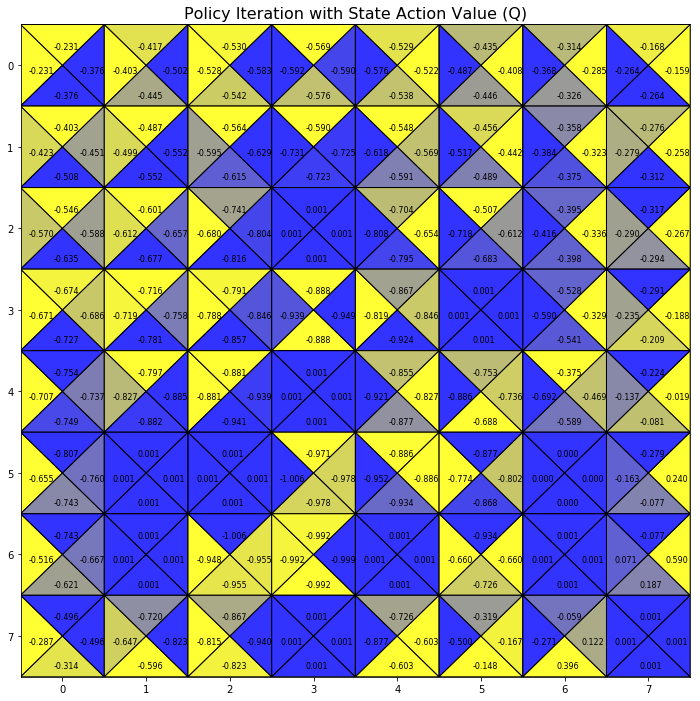

In [4]:
def q_value_iteration(env,gamma=0.999,epsilon=1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_action = act_space.n
    
    P = np.zeros((n_state,n_action,n_state))
    r = np.zeros((n_state,n_action,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward

    q = np.random.uniform(size=(n_state,n_action))
    
    while True: 
        v = np.max(q,axis=1)
        q_prime = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_action,1)))*P,axis=2)
        dist = np.max(np.max(np.abs(q-q_prime)))
        q = q_prime
        if dist < epsilon:
            break

    policy = np.zeros((n_state,n_action))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1
    
    return policy, q

if __name__=='__main__': 
    policy,q = q_value_iteration(env)
    display_q_value(q,title="Policy Iteration with State Action Value (Q)")

# Q Learning

For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$

Update Q value using temporal difference (TD) target and error!!

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1})$ is needed.
$A_{t+1}$ is not needed.

TD target is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

TD error is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

Algorithm
--
---
For every time step

Policy Evaluation

- $(S_{t},A_{t},R_{t+1},S_{t+1}$

- $TDtarget = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

- $TDerror = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

- $Q[S_{t}, A_{t}] = Q[S_{t}, A_{t}] + \alpha TDerror$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [5]:
class  QLearningAgent():
    def __init__(self, n_state, n_action, alpha=0.5, gamma=0.999,
                 exploration="EpsGrdy", epsilon=1.0):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        self.alpha = alpha
        self.gamma = gamma
        self.exploration = exploration
        if self.exploration == "EpsGrdy":
            self.epsilon = epsilon

    def update_value(self, state, action, reward, next_state, done): #(S,A,R,S')
        q_old = self.q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q[next_state])
        td_error = td_target - q_old # TD error
        self.q[state, action] = q_old + self.alpha * td_error # Update Q

    def update_policy(self, update_rate):
        if self.exploration == "EpsGrdy":
            self.epsilon = np.min([update_rate,1])
            
    def update_alpha(self, update_rate):
        self.alpha = np.min([update_rate,1])
        
    def get_action(self, state):
        if self.exploration == "EpsGrdy":
            if np.random.uniform() < self.epsilon:
                action = np.random.randint(0, high=self.n_action)
            else:
                action = np.argmax(self.q[state])
        elif self.exploration == "Random":
            action = np.random.randint(0, high=self.n_action)
        return action
    
if __name__=='__main__': 
    qlearningagent = QLearningAgent(n_state,n_action)

# Run Q Learning Agent

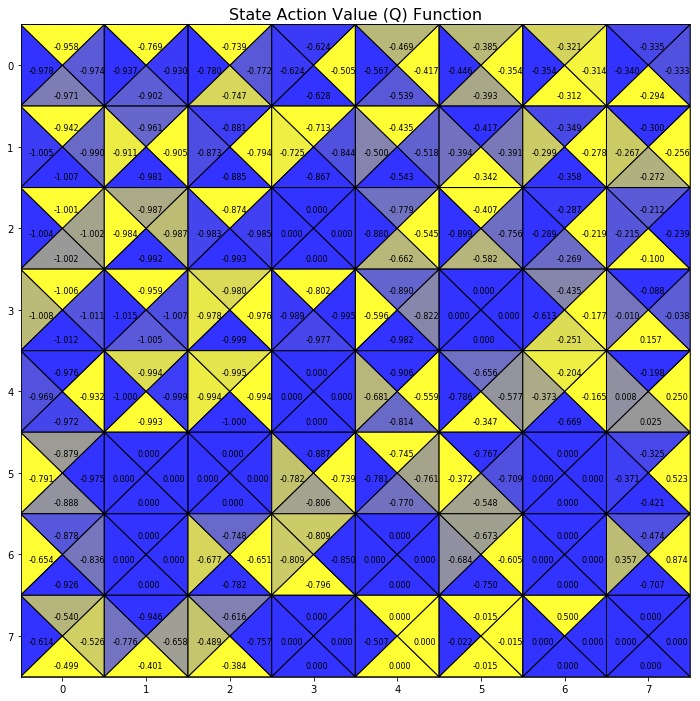

In [6]:
n_episode = 3000
for episode in range(n_episode):
    state = env.reset()
    action = qlearningagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = qlearningagent.get_action(next_state)

        qlearningagent.update_value(state, action, reward, next_state, done)
        
        state = next_state
        action = next_action
    qlearningagent.update_policy(1000/(episode+1))
display_q_value(qlearningagent.q)

# Run Q Learning Agent with Random Policy

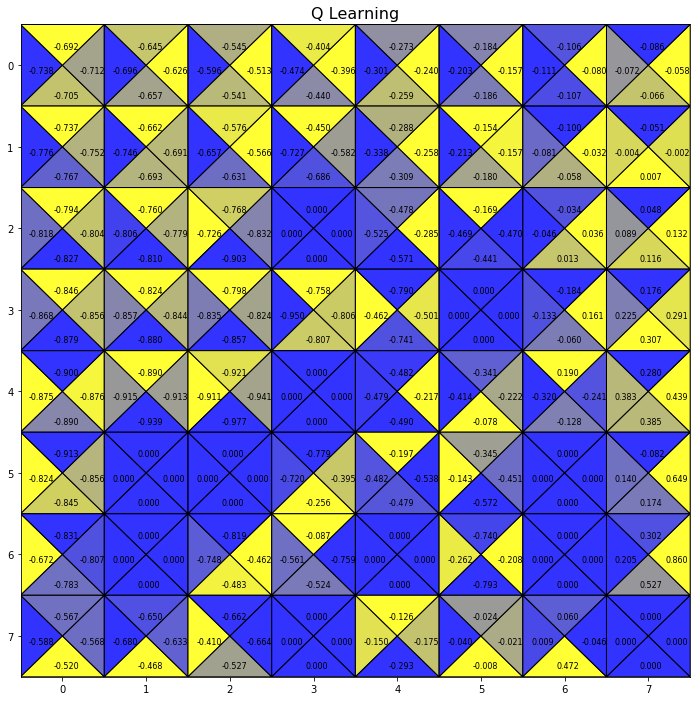

In [7]:
qlearning_random_agent  = QLearningAgent(n_state,n_action,alpha=1.0,exploration="Random")
n_episode = 30000
for episode in range(n_episode):
    state = env.reset()
    action = qlearning_random_agent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = qlearning_random_agent.get_action(next_state)

        qlearning_random_agent.update_value(state, action, reward, next_state, done)
        
        state = next_state
        action = next_action
    qlearning_random_agent.update_alpha(1000/(episode+1))
display_q_value(qlearning_random_agent.q,title="Q Learning")

# Q($\lambda$) Learning

In [8]:
class QlambdaLearningAgent():
    def __init__(self, n_state, n_action, alpha=0.05, gamma=0.999, lam=0.6, exploration="EpsGrdy", epsilon=1.0):
        
        self.n_state = n_state
        self.n_action = n_action
        
        self.q = np.zeros([n_state,n_action])
        self.eligibility_trace = np.zeros([n_state,n_action])
        
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.exploration = exploration
        if self.exploration == "EpsGrdy":
            self.epsilon = epsilon

    def update_value(self, state, action, reward, next_state, done):
        q_old = self.q[state][action]
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q[next_state])
        td_error = td_target - q_old
        
        self.eligibility_trace[state][action] += 1
        
        self.q = self.q + self.alpha * td_error * self.eligibility_trace
        
        self.eligibility_trace = self.gamma * self.lam * self.eligibility_trace
        
    def update_policy(self, update_rate):
        if self.exploration == "EpsGrdy":
            self.epsilon = self.epsilon*np.min([update_rate,1])
        
    def get_action(self, state):
        if self.exploration == "EpsGrdy":
            if np.random.uniform() < self.epsilon:
                action = np.random.randint(0, high=self.n_action)
            else:
                action = np.argmax(self.q[state])
        elif self.exploration == "Random":
            action = np.random.randint(0, high=self.n_action)
        return action
       
if __name__=='__main__': 
    qlambdaagent = QlambdaLearningAgent(n_state,n_action)

# Run Q($\lambda$) Learning Agent

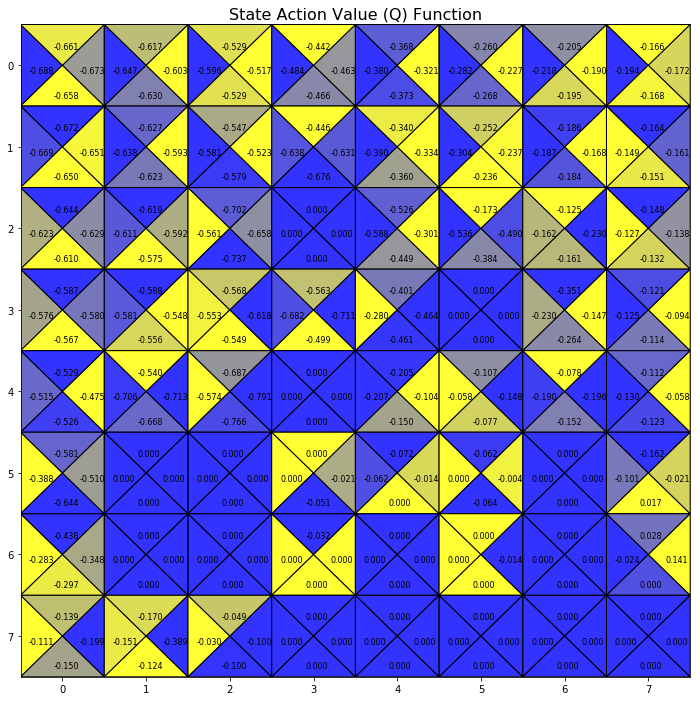

In [9]:
n_episode = 1000
for episode in range(n_episode):
    state = env.reset()
    action = qlambdaagent.get_action(state)
    done = False
    while not done:    
        
        next_state, reward, done, info = env.step(action)
        next_action = qlambdaagent.get_action(next_state)

        qlambdaagent.update_value(state, action, reward, next_state, done)
        
        state = next_state
        action = next_action
    qlambdaagent.update_policy(1000/(episode+1))
display_q_value(qlambdaagent.q)